# Credit Card Customer Segmentation

- [Introduction](#intro)
- [Prepare Data](#prepare)
- [Explore](#explore)
- [Build](#build)
- [Communicate Results](#communicate)

## Introduction
<a id="intro"></a>

This project aims to develop a model for customer segmentation for a credit card company, so it can be used a basis for a marketing strategy. The dataset, which was obtained from [Kaggle](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata), contains information of over 8,500 customers collected over a 6-month period. It has 18 features representing customer characteristics, including purchase behaviour, credit limit and other financial factors.

## Prepare Data
<a id="prepare"></a>

### Import

In [32]:
# Import libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('CC GENERAL.csv')
print(df.shape)
df.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### Wrangle data

In [3]:
# Make column headers lowercase for accessibility
df.columns = df.columns.str.lower()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

In [5]:
# Drop cust_id
df.drop(columns='cust_id', inplace=True)

In [6]:
df.isna().sum()

balance                               0
balance_frequency                     0
purchases                             0
oneoff_purchases                      0
installments_purchases                0
cash_advance                          0
purchases_frequency                   0
oneoff_purchases_frequency            0
purchases_installments_frequency      0
cash_advance_frequency                0
cash_advance_trx                      0
purchases_trx                         0
credit_limit                          1
payments                              0
minimum_payments                    313
prc_full_payment                      0
tenure                                0
dtype: int64

In [7]:
# Drop missings values
df.dropna(inplace=True)

In [8]:
df.describe()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
count,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000
mean,1601.224893,0.895035,1025.433874,604.901438,420.843533,994.175523,0.496000,0.205909,0.368820,0.137604,3.313918,15.033233,4522.091030,1784.478099,864.304943,0.159304,11.534391
std,2095.571300,0.207697,2167.107984,1684.307803,917.245182,2121.458303,0.401273,0.300054,0.398093,0.201791,6.912506,25.180468,3659.240379,2909.810090,2372.566350,0.296271,1.310984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.000000
25%,148.095189,0.909091,43.367500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,418.559237,169.163545,0.000000,12.000000
50%,916.855459,1.000000,375.405000,44.995000,94.785000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,896.675701,312.452292,0.000000,12.000000
75%,2105.195853,1.000000,1145.980000,599.100000,484.147500,1132.385490,0.916667,0.333333,0.750000,0.250000,4.000000,18.000000,6500.000000,1951.142090,825.496463,0.166667,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## Explore
<a id='explore'></a>

### Distribution of Balance

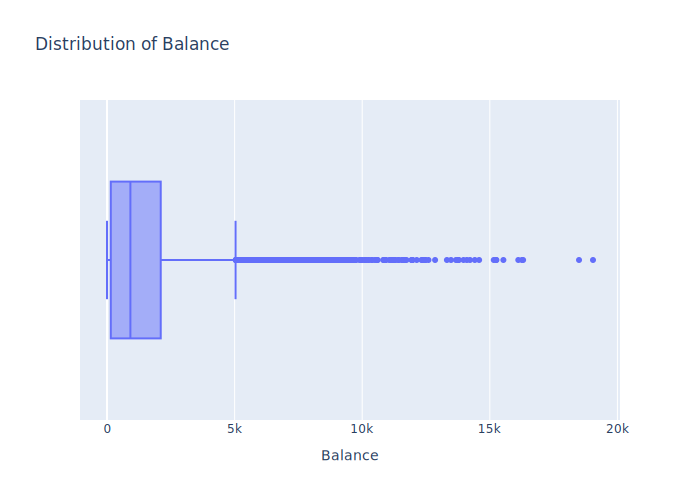

In [9]:
# Create boxplot of Balance
fig = px.box(
    df,
    x='balance',
    title='Distribution of Balance'
)
fig.update_layout(xaxis_title='Balance')
fig.show('svg')

Before building the model, we need to determine what features to use for our model. A good criteria to use would be looking at the variance of each feature as higher variance features would generally lead to better clusters.

In [10]:
# Calculate variance
variance = df.var().sort_values()
variance

cash_advance_frequency              4.071978e-02
balance_frequency                   4.313799e-02
prc_full_payment                    8.777645e-02
oneoff_purchases_frequency          9.003217e-02
purchases_installments_frequency    1.584780e-01
purchases_frequency                 1.610197e-01
tenure                              1.718678e+00
cash_advance_trx                    4.778274e+01
purchases_trx                       6.340560e+02
installments_purchases              8.413387e+05
oneoff_purchases                    2.836893e+06
balance                             4.391419e+06
cash_advance                        4.500585e+06
purchases                           4.696357e+06
minimum_payments                    5.629071e+06
payments                            8.466995e+06
credit_limit                        1.339004e+07
dtype: float64

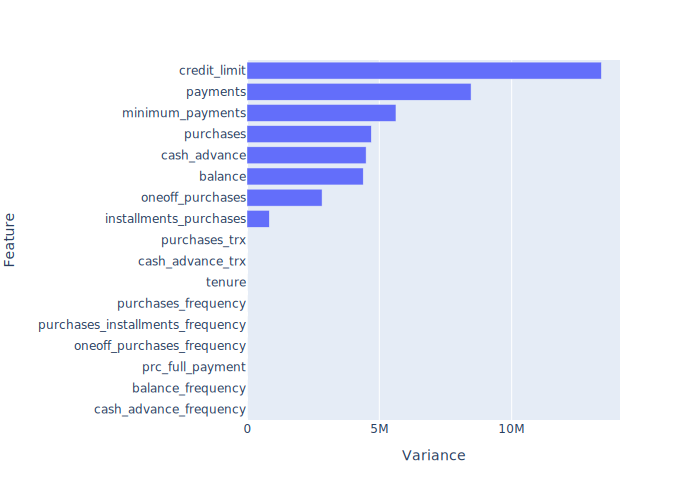

In [11]:
# Create horizontal bar chart of variance
fig = px.bar(
    x=variance,
    y=variance.index,
    title=''
)
fig.update_layout(xaxis_title='Variance', yaxis_title='Feature')
fig.show('svg')

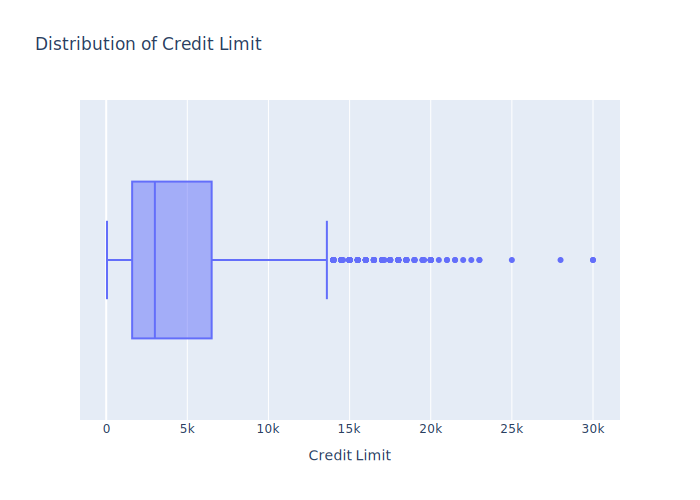

In [12]:
# Create boxplot of Balance
fig = px.box(
    df,
    x='credit_limit',
    title='Distribution of Credit Limit'
)
fig.update_layout(xaxis_title='Credit Limit')
fig.show('svg')

The distribution of our data is right skewed as some customers have features much higher that majority of the other customers as seen in the boxplot of `balance` and `credit_limit`. These outliers have made the variance larger than needed, so we will use trimmed variance to calculate the variance without the outliers.

In [13]:
# Calculate trimmed variance
trimmed_variance = df.apply(trimmed_var).sort_values()
trimmed_variance

balance_frequency                   1.155681e-02
cash_advance_frequency              1.489964e-02
prc_full_payment                    2.586559e-02
oneoff_purchases_frequency          3.666214e-02
tenure                              8.742538e-02
purchases_installments_frequency    1.302225e-01
purchases_frequency                 1.387657e-01
cash_advance_trx                    6.464722e+00
purchases_trx                       8.818169e+01
installments_purchases              8.823619e+04
minimum_payments                    1.614683e+05
oneoff_purchases                    1.646010e+05
purchases                           4.075150e+05
cash_advance                        6.288407e+05
payments                            8.155695e+05
balance                             1.155988e+06
credit_limit                        5.367024e+06
dtype: float64

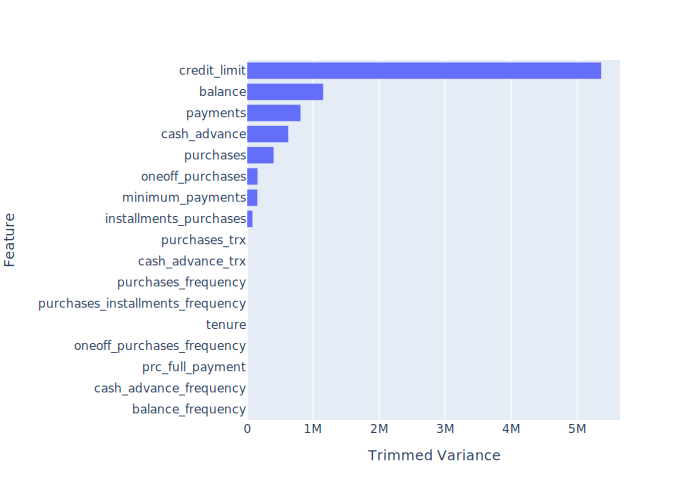

In [14]:
fig = px.bar(
    x=trimmed_variance,
    y=trimmed_variance.index
)
fig.update_layout(xaxis_title='Trimmed Variance', yaxis_title='Feature')
fig.show('svg')

We have the same features for normal variance and trimmed variance. So we will use the top 5 features with highest trimmed variance. 

In [15]:
# Top 5 features
high_var_col = trimmed_variance.tail(5)
high_var_col

purchases       4.075150e+05
cash_advance    6.288407e+05
payments        8.155695e+05
balance         1.155988e+06
credit_limit    5.367024e+06
dtype: float64

## Build Model
<a id='build'></a>

### Split

In [16]:
# Create feature matrix
X = df[high_var_col.index]
print(X.shape)
X.head()

(8636, 5)


,purchases,cash_advance,payments,balance,credit_limit
0,95.40,0.000000,201.802084,40.900749,1000.0
1,0.00,6442.945483,4103.032597,3202.467416,7000.0
2,773.17,0.000000,622.066742,2495.148862,7500.0
4,16.00,0.000000,678.334763,817.714335,1200.0
5,1333.28,0.000000,1400.057770,1809.828751,1800.0


### Iterate

First, we need to figure out how many clusters would be optimal for our project. To do this, we will evaluate inertia errors and silhouette scores across a number of clusters using a for loop

In [17]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# For loop to train model and calculate inertia errors and silhouette scores
for k in n_clusters:
    # build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    # train model
    model.fit(X)
    # Calculate inertia
    inertia_errors.append(model.named_steps['kmeans'].inertia_)
    # Calculate Silhouette scores
    silhouette_scores.append(silhouette_score(X, model.named_steps['kmeans'].labels_))
    
print('Inertia:', inertia_errors)
print()
print('Silhouette Scores:', silhouette_scores)

Inertia: [30104.798815236252, 24801.249820553185, 21087.941529338605, 18206.02803512776, 15975.716151322082, 14300.125181122177, 13205.729685783728, 12345.696781179748, 11607.081799579257, 10936.581474389124, 10356.095200571512]

Silhouette Scores: [0.5465904221216482, 0.4924658650928145, 0.4321723846465909, 0.4598459579078072, 0.42186480457829156, 0.4197750464655628, 0.3894180059049332, 0.3618177039428288, 0.3461004585141672, 0.3557026491260196, 0.35786508751192364]


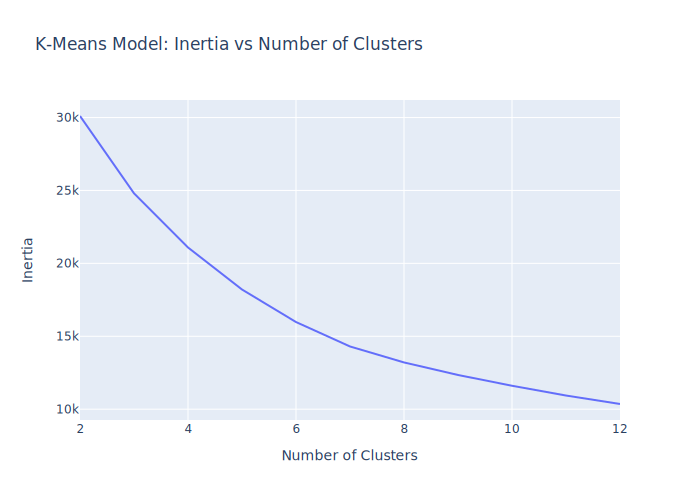

In [18]:
# Create line plot of inertia_errors vs n_clusters
fig = px.line(
    x=n_clusters,
    y=inertia_errors,
    title='K-Means Model: Inertia vs Number of Clusters'
)
fig.update_layout(xaxis_title='Number of Clusters', yaxis_title='Inertia')
fig.show('svg')

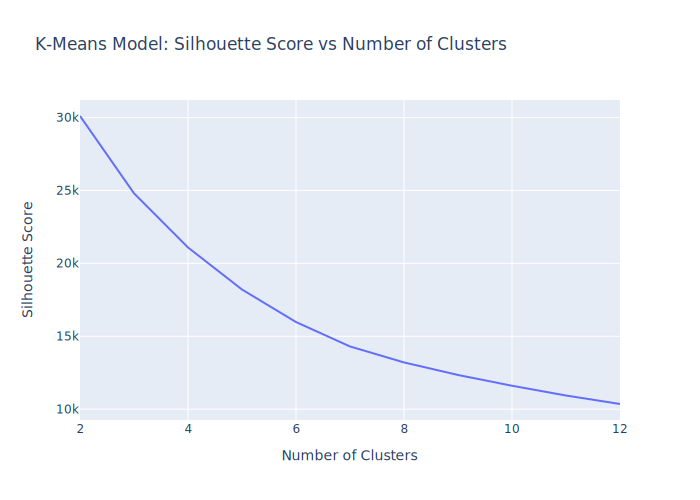

In [19]:
# Create line plot of silhouette_scores vs n_clusters
fig = px.line(
    x=n_clusters,
    y=inertia_errors,
    title='K-Means Model: Silhouette Score vs Number of Clusters'
)
fig.update_layout(xaxis_title='Number of Clusters', yaxis_title='Silhouette Score')
fig.show('svg')

Looking at both plots, it seems the best number of clusters will be 4.

In [20]:
# build final model 
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

## Communicate Results
<a id='communicate'></a>

In [21]:
labels = final_model.named_steps['kmeans'].labels_
print(labels[:10])

[2 1 2 2 2 1 2 2 2 2]


In [22]:
# Calculate mean for features in each clusters
x_group = X.groupby(labels).mean()
x_group

,purchases,cash_advance,payments,balance,credit_limit
0,11151.973175,5152.512394,18062.136579,4757.961607,12397.619048
1,1416.437842,3079.597093,3329.907385,4535.433844,9073.317591
2,748.602688,428.953250,1124.396259,855.197807,3310.477816


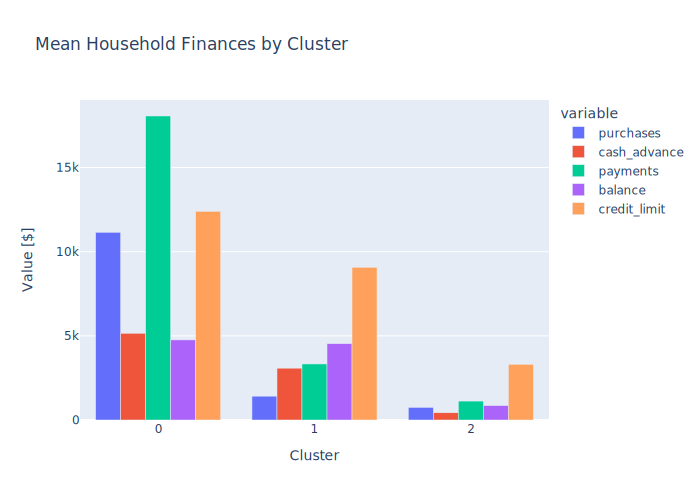

In [23]:
# Create side-by-side bar plot of x_group
fig = px.bar(
    x_group,
    barmode='group',
    title='Mean Household Finances by Cluster'
)
fig.update_layout(xaxis_title='Cluster', yaxis_title='Value [$]')
fig.show('svg')

The plot above shows a very clear difference between each cluster with Cluster 0 showing customers who have high credit limits and so they have high purchases and payments, customers with mid-level credit limits with low purchases and payments and then customers with smaller credit limits and therefore even lower purchases and payments.

We will use principal component analysis (PCA) to reduce dimensionality so we can plot see the spread of our clusters across features.

In [24]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=['PC1', 'PC2'])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (8636, 2)


,PC1,PC2
0,-4319.249250,722.808147
1,4469.747404,-262.654556
2,1572.671349,-2776.792582
3,-3725.123423,754.518972
4,-2273.814669,1283.315205


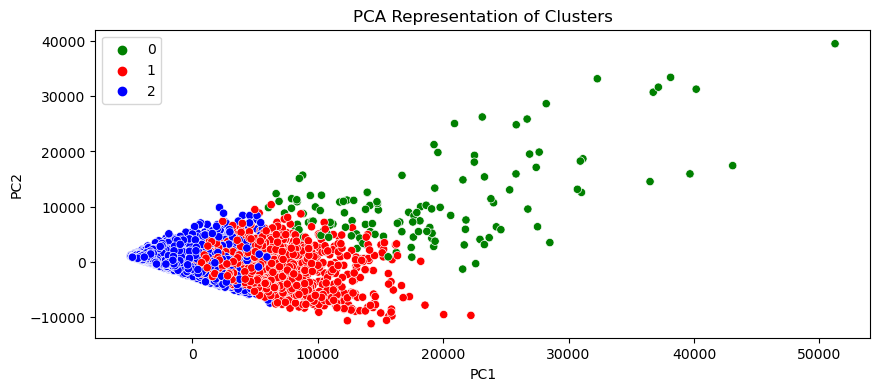

In [38]:
fig, ax = plt.subplots(figsize=[10,4])
sns.scatterplot(
    data=X_pca,
    x='PC1',
    y='PC2',
    hue=labels,
    palette=['green', 'red', 'blue'],
    ax = ax
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Representation of Clusters');

One limitation of this plot is that it is hard to explain what the axes represent. Using PCA, we were able to combine all the features into a 2d plot to show the spread of customers in each cluster.